In [14]:
import numpy as np
import umap

import logging
import matplotlib.pyplot as plt
from cycler import cycler
from PIL import Image

import torchvision
import torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import pytorch_metric_learning
from pytorch_metric_learning import distances, losses, miners, reducers, testers, trainers, samplers
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [2]:
logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

INFO:root:VERSION 2.4.1


In [3]:
class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=False))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]

    def forward(self, x):
        return self.net(x)

In [4]:
# device = torch.device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
# Taken from MNIST I guess? To check?

transform = transforms.Compose(
    [
       transforms.Resize(32),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Do not normalize the image to visualize it properly
transform_img = transforms.Compose(
    [
       transforms.Resize(32),
       transforms.ToTensor(),
    ]
)

batch_size = 256
num_epochs = 1

In [50]:
train_image_dataset = datasets.CIFAR10(".", train=True, download=True, transform=transform_img)
train_dataset = datasets.CIFAR10(".", train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(".", train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


image tensor: torch.Size([10, 3, 32, 32])
class labels: tensor([3, 3, 8, 3, 6, 2, 0, 1, 2, 1])


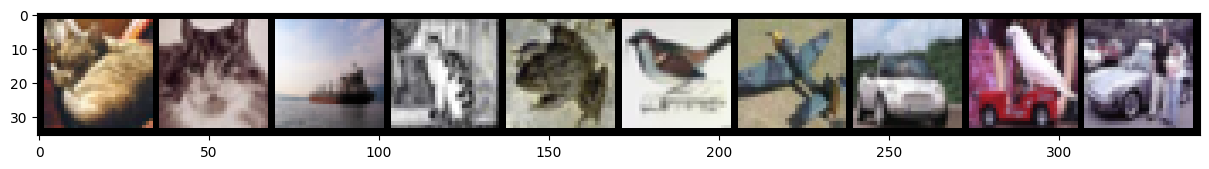

In [51]:
data_loader = torch.utils.data.DataLoader(train_image_dataset, batch_size=10, shuffle=True)
sample = next(iter(data_loader))

imgs, lbls = sample

# create a grid 
plt.figure(figsize=(15,10))
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {lbls}")
# plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');
plt.imshow(np.transpose(grid, axes=(1,2,0)));

In [52]:
record_keeper, _, _ = logging_presets.get_record_keeper(
    "example_logs", "example_tensorboard"
)

hooks = logging_presets.get_hook_container(record_keeper)

def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    logging.info(
        "UMAP plot for the {} split and label set {}".format(split_name, keyname)
    )
    label_set = np.unique(labels)
    num_classes = len(label_set)
    plt.figure(figsize=(20, 15))
    plt.gca().set_prop_cycle(
        cycler(
            "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
        )
    )
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)
    plt.show()

In [53]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [54]:
tester = testers.GlobalEmbeddingSpaceTester(
    end_of_testing_hook=hooks.end_of_testing_hook,
    visualizer=umap.UMAP(),
    visualizer_hook=visualizer_hook,
    dataloader_num_workers=2,
    accuracy_calculator=AccuracyCalculator(k="max_bin_count"),
)

dataset_dict = {"val": val_dataset, "train": train_dataset}
model_folder = "example_saved_models"

end_of_epoch_hook = hooks.end_of_epoch_hook(
    tester, 
    dataset_dict, 
    model_folder, 
    test_interval=1, 
    patience=10,
)

In [16]:
torchsummary.summary?

Signature: torchsummary.summary(model, input_size, batch_size=-1, device='cuda')
Docstring: <no docstring>
File:      ~/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/torchsummary/torchsummary.py
Type:      function

In [ ]:
print(embedder)

In [21]:
print(trunk)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [55]:
# Set the loss function
loss = losses.TripletMarginLoss(margin=0.2)

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)

# Set the mining function
miner = miners.TripletMarginMiner(
    margin=0.2, 
    distance=distance, 
    type_of_triplets="semihard",
)

# Set the dataloader sampler
sampler = samplers.MPerClassSampler(
    train_dataset.targets, 
    m=4, 
    length_before_new_iter=len(train_dataset),
)

# FIXME
sampler = None

trunk = torchvision.models.resnet18(pretrained=True)
trunk_output_size = trunk.fc.in_features
trunk.fc = nn.Identity()
trunk = torch.nn.DataParallel(trunk.to(device))

# Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
emb_size = 64
embedder = torch.nn.DataParallel(MLP([trunk_output_size, emb_size]).to(device))
models = {"trunk": trunk, "embedder": embedder}

embedder_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.01, weight_decay=0.001)
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.0001, weight_decay=0.001)

optimizers = {
    "trunk_optimizer": trunk_optimizer,
    "embedder_optimizer": embedder_optimizer,
    # "classifier_optimizer": classifier_optimizer,
}

loss_funcs = {
    "metric_loss": loss_func, 
    # "classifier_loss": classification_loss,
}
mining_funcs = {"tuple_miner": miner}
# mining_funcs = None

# We can specify loss weights if we want to. This is optional
loss_weights = {
    "metric_loss": 1, 
    # "classifier_loss": 0.5,
}

trainer = trainers.MetricLossOnly(
    models,
    optimizers,
    batch_size,
    loss_funcs,
    train_dataset,
    mining_funcs=mining_funcs,
    sampler=sampler,
    dataloader_num_workers=2,
    loss_weights=loss_weights,
    end_of_iteration_hook=hooks.end_of_iteration_hook,
    end_of_epoch_hook=end_of_epoch_hook,
)

/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the val split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.36it/s]
INFO:PML:Running UMAP on the val set
/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


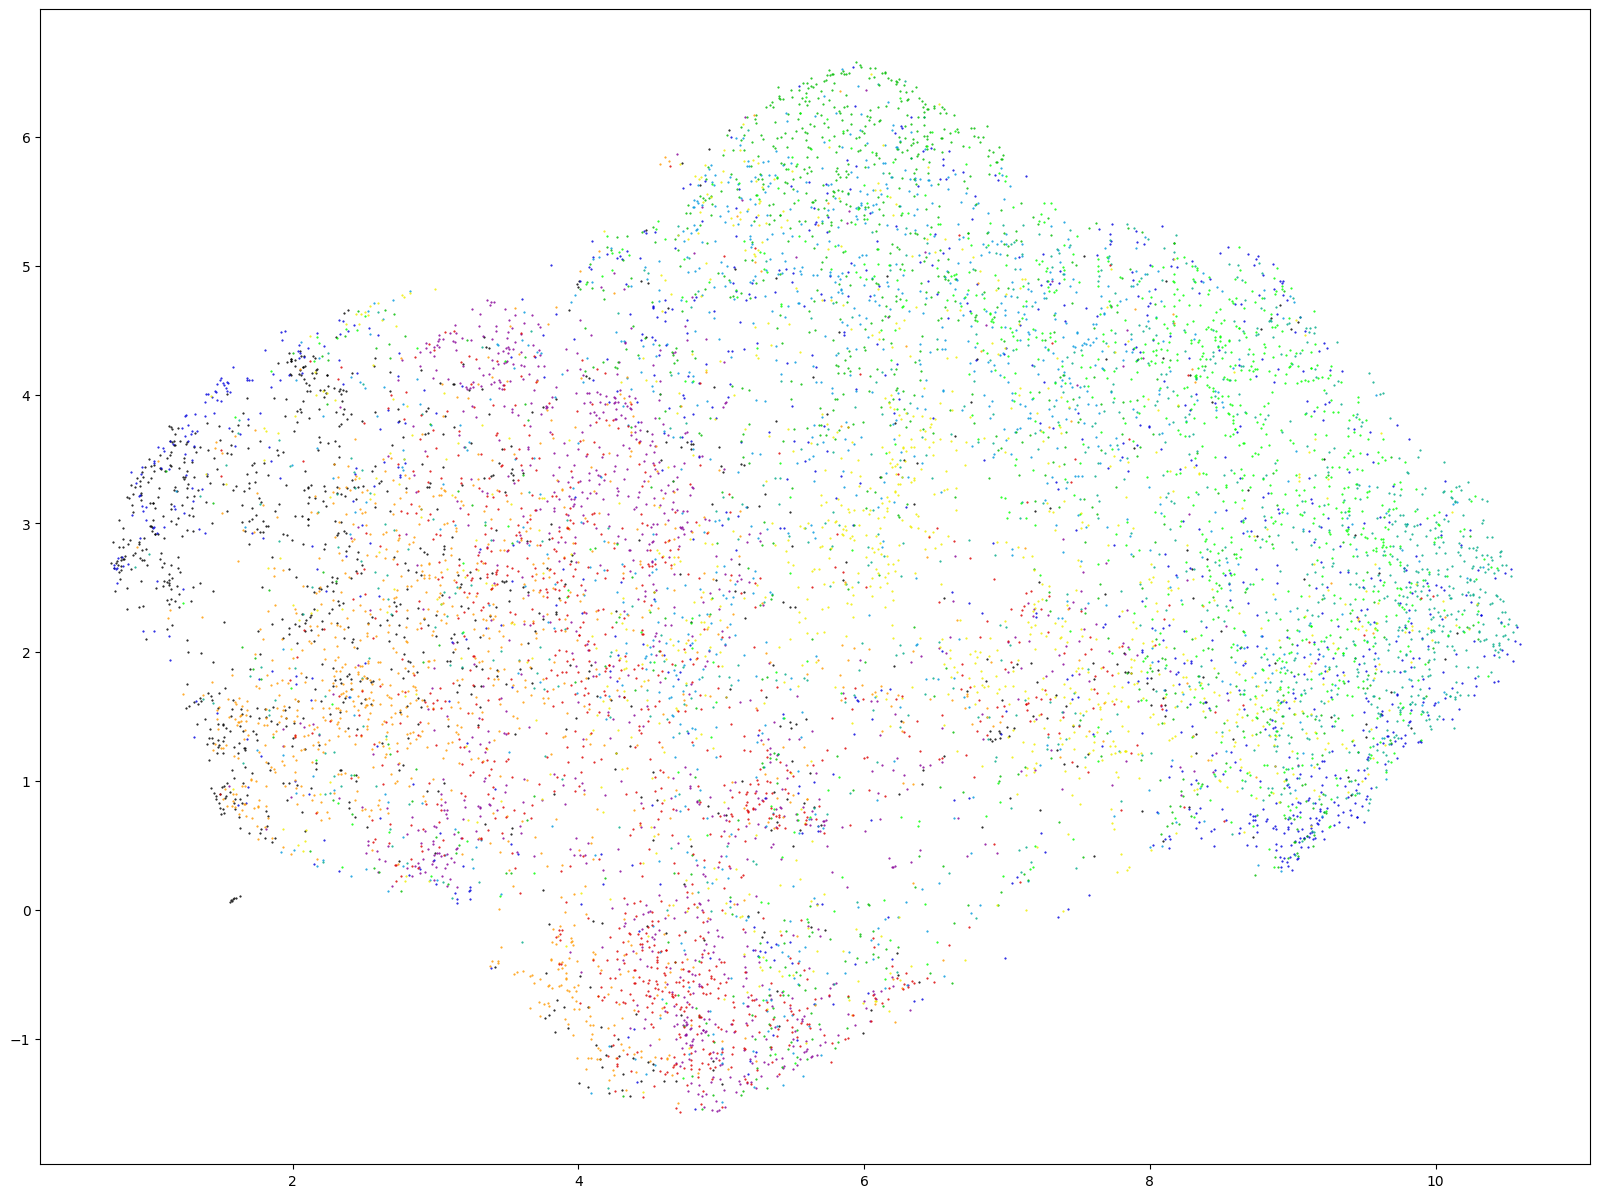

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=1000
INFO:PML:embedding dimensionality is 512
/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)
INFO:PML:running k-means clustering with k=10
INFO:PML:embedding dimensionality is 512


defaultdict(dict,
            {'val': {'epoch': 1,
              'AMI_level0': 0.18939364339844797,
              'NMI_level0': 0.19082553971751076,
              'mean_average_precision_level0': 0.08368568794198873,
              'mean_average_precision_at_r_level0': 0.08368568794198873,
              'mean_reciprocal_rank_level0': 0.6194950938224792,
              'precision_at_1_level0': 0.4736,
              'r_precision_level0': 0.23170220220220217}})

In [56]:
tester.test(dataset_dict, 1, trunk)

INFO:PML:Initializing dataloader
INFO:PML:Initializing dataloader iterator
INFO:PML:Done creating dataloader iterator
INFO:PML:TRAINING EPOCH 1
total_loss=0.19957: 100%|████████████████████████████████████████████████████████████████████████████████████████| 195/195 [06:35<00:00,  2.03s/it]
INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the val split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:18<00:00, 16.90it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


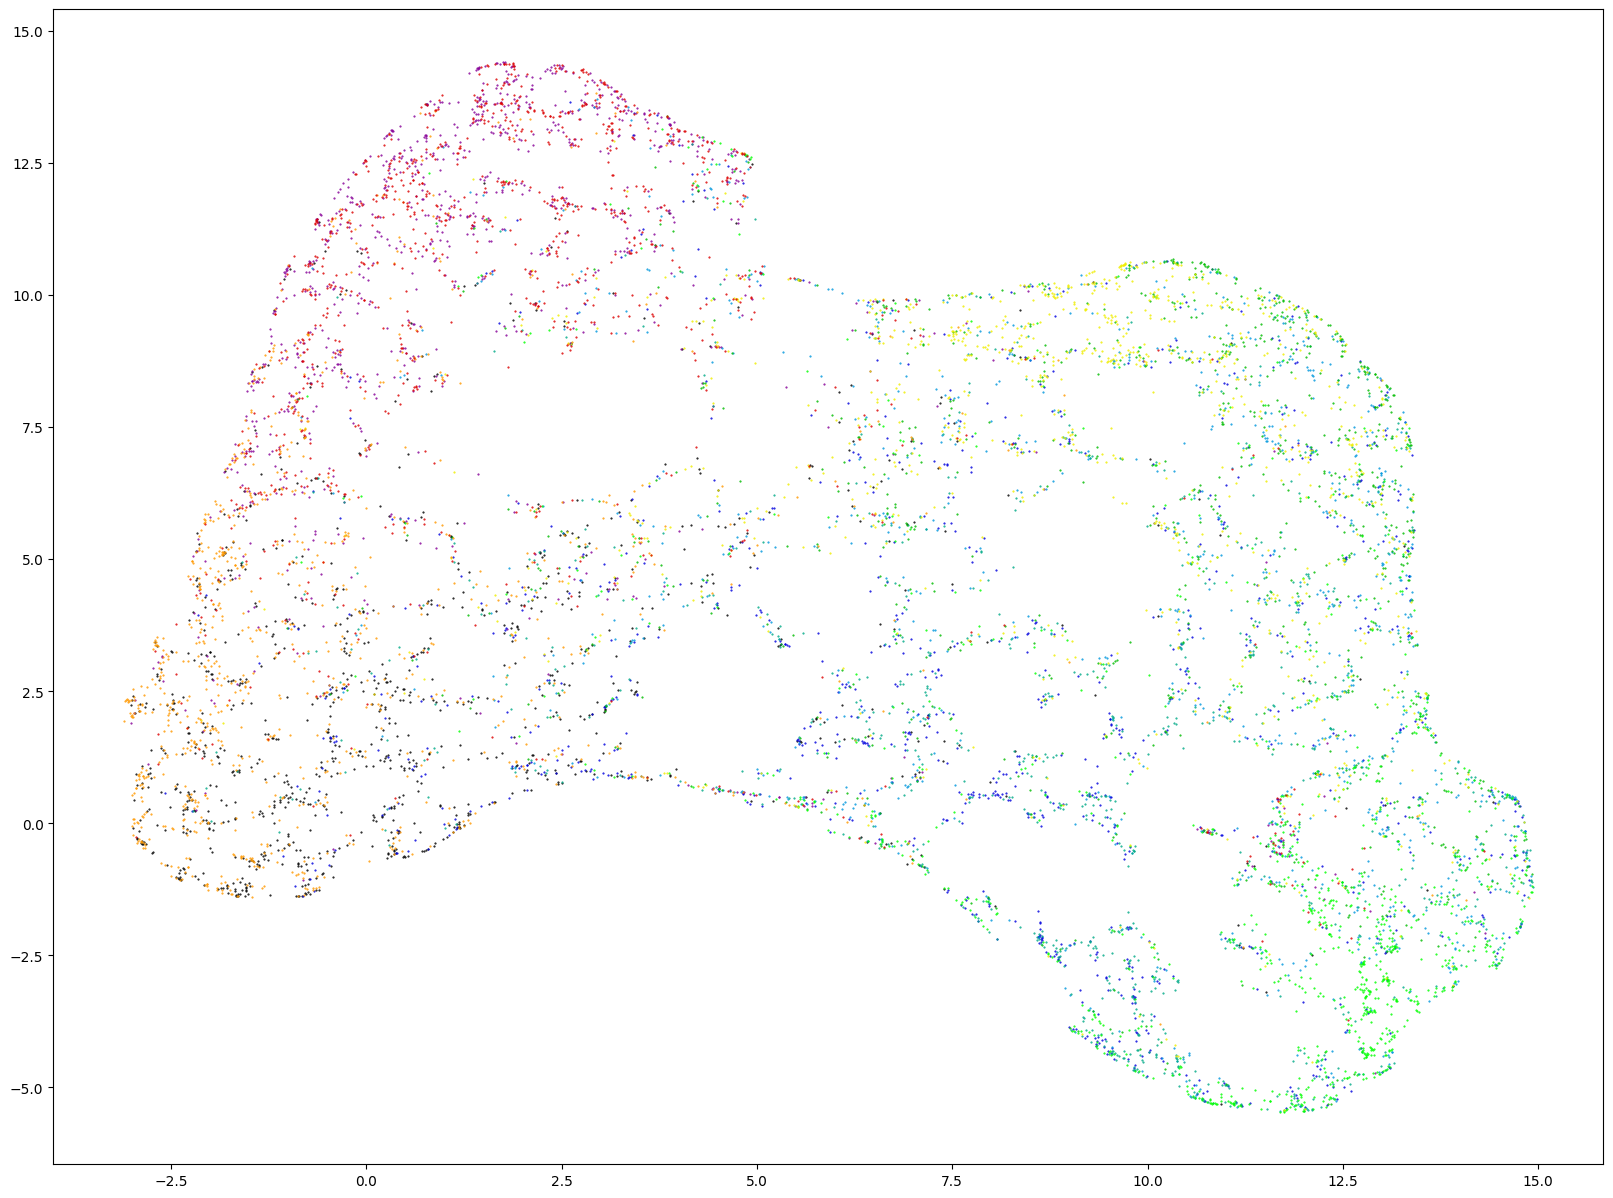

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=1000
INFO:PML:embedding dimensionality is 64
INFO:PML:running k-means clustering with k=10
INFO:PML:embedding dimensionality is 64
INFO:PML:TRAINING EPOCH 2
total_loss=0.19885: 100%|████████████████████████████████████████████████████████████████████████████████████████| 195/195 [06:35<00:00,  2.03s/it]
INFO:PML:Evaluating epoch 2
INFO:PML:Getting embeddings for the val split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 16.34it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


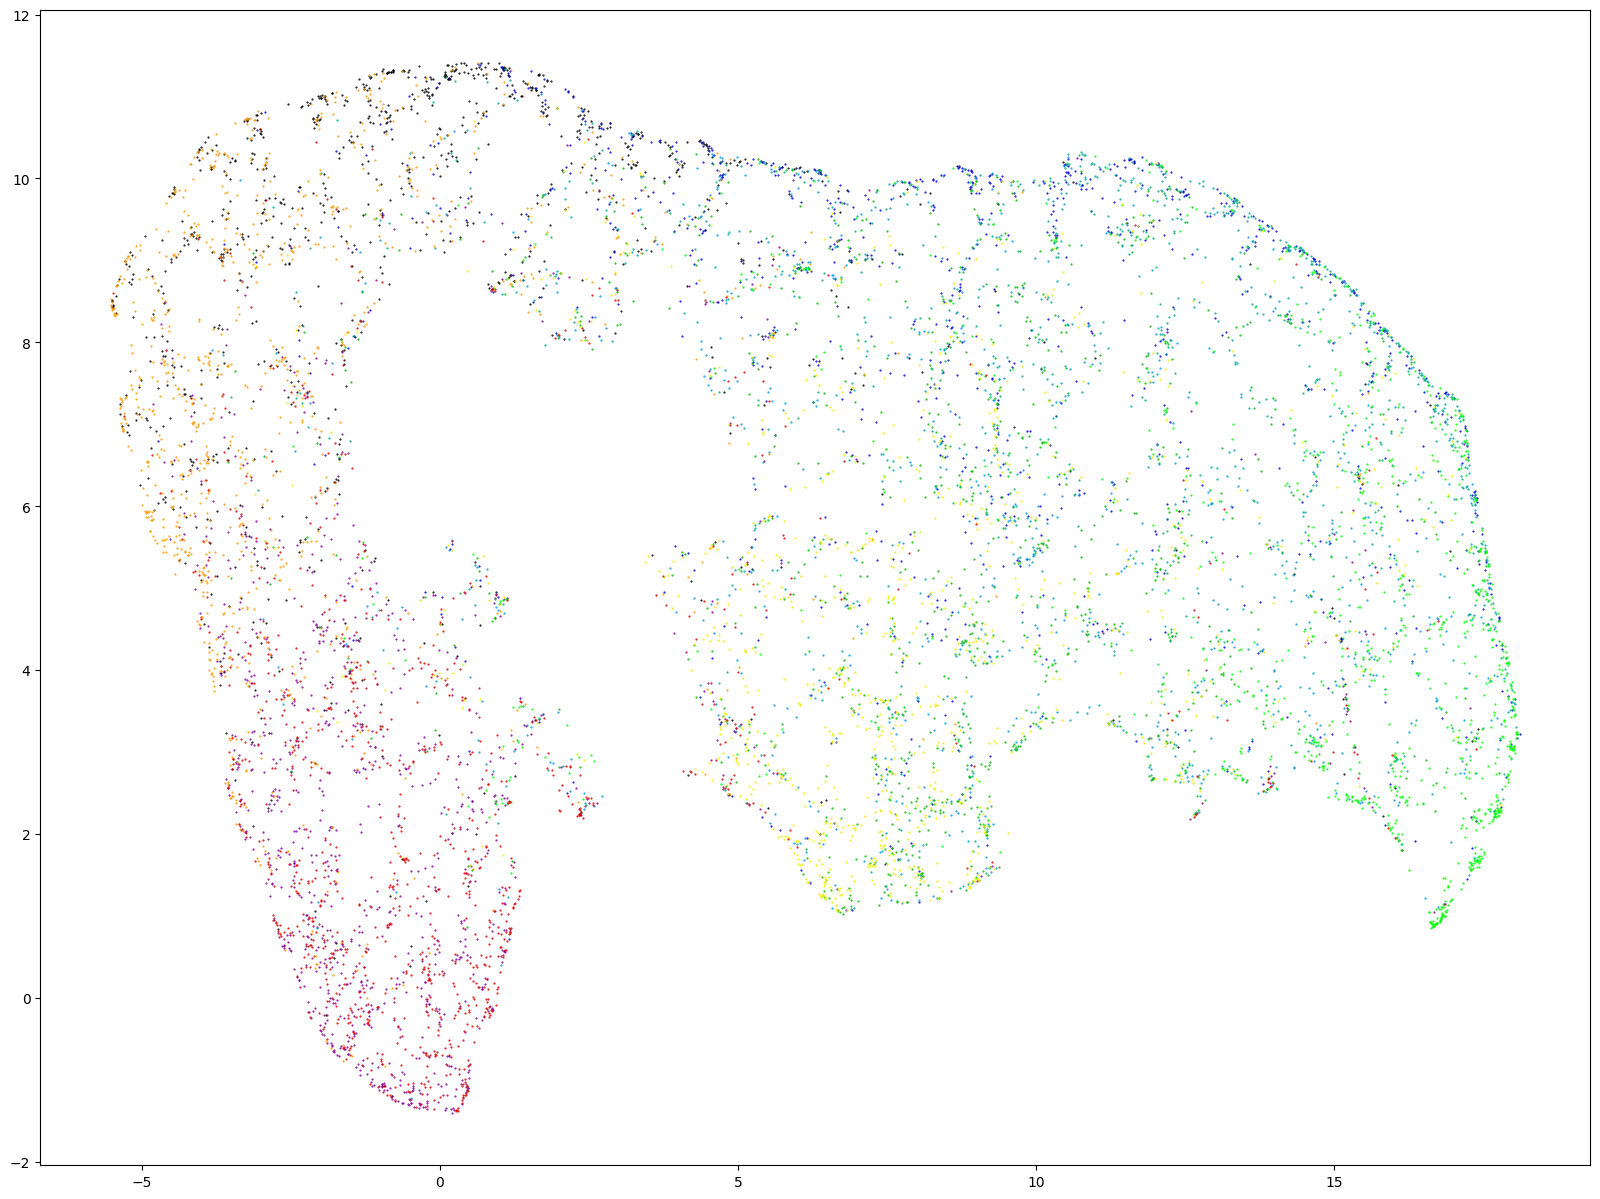

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=1000
INFO:PML:embedding dimensionality is 64
INFO:PML:running k-means clustering with k=10
INFO:PML:embedding dimensionality is 64
INFO:PML:TRAINING EPOCH 3
total_loss=0.17642: 100%|████████████████████████████████████████████████████████████████████████████████████████| 195/195 [07:27<00:00,  2.30s/it]
INFO:PML:Evaluating epoch 3
INFO:PML:Getting embeddings for the val split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:17<00:00, 18.00it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


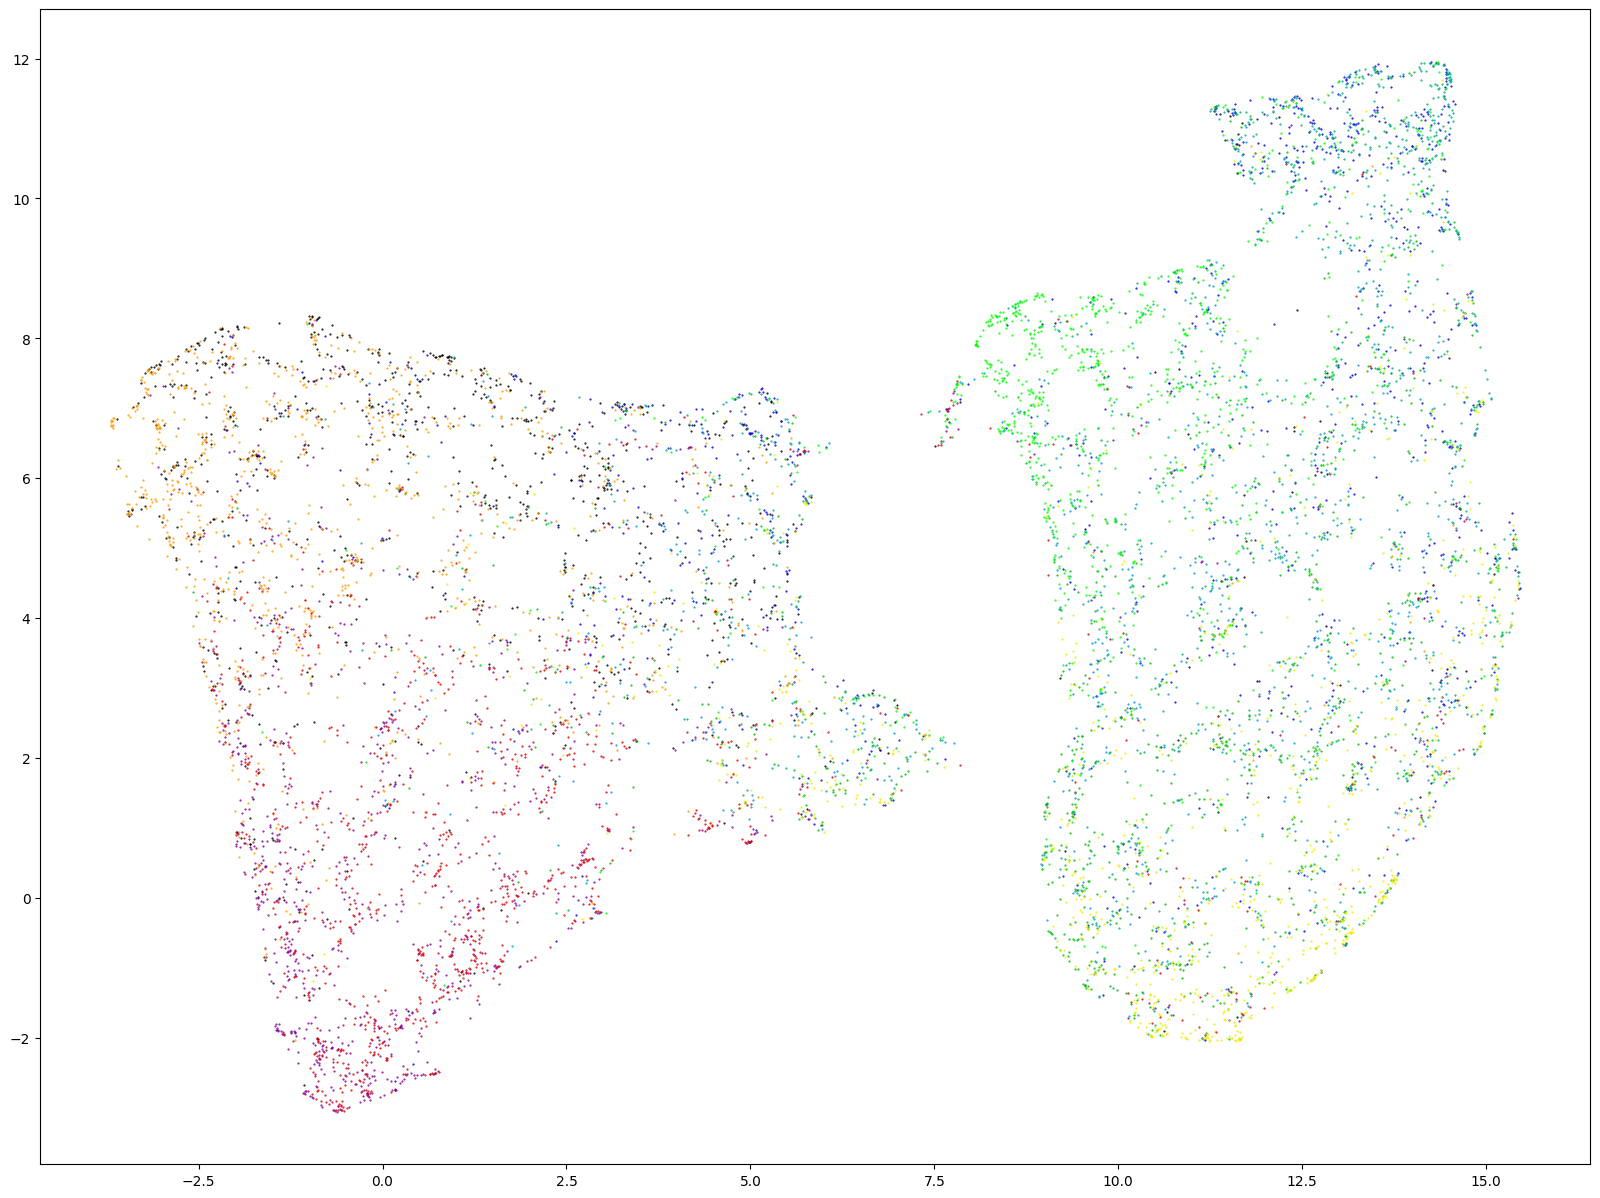

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=1000
INFO:PML:embedding dimensionality is 64
INFO:PML:running k-means clustering with k=10
INFO:PML:embedding dimensionality is 64
INFO:PML:TRAINING EPOCH 4
total_loss=0.18836: 100%|████████████████████████████████████████████████████████████████████████████████████████| 195/195 [09:12<00:00,  2.83s/it]
INFO:PML:Evaluating epoch 4
INFO:PML:Getting embeddings for the val split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 21.60it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


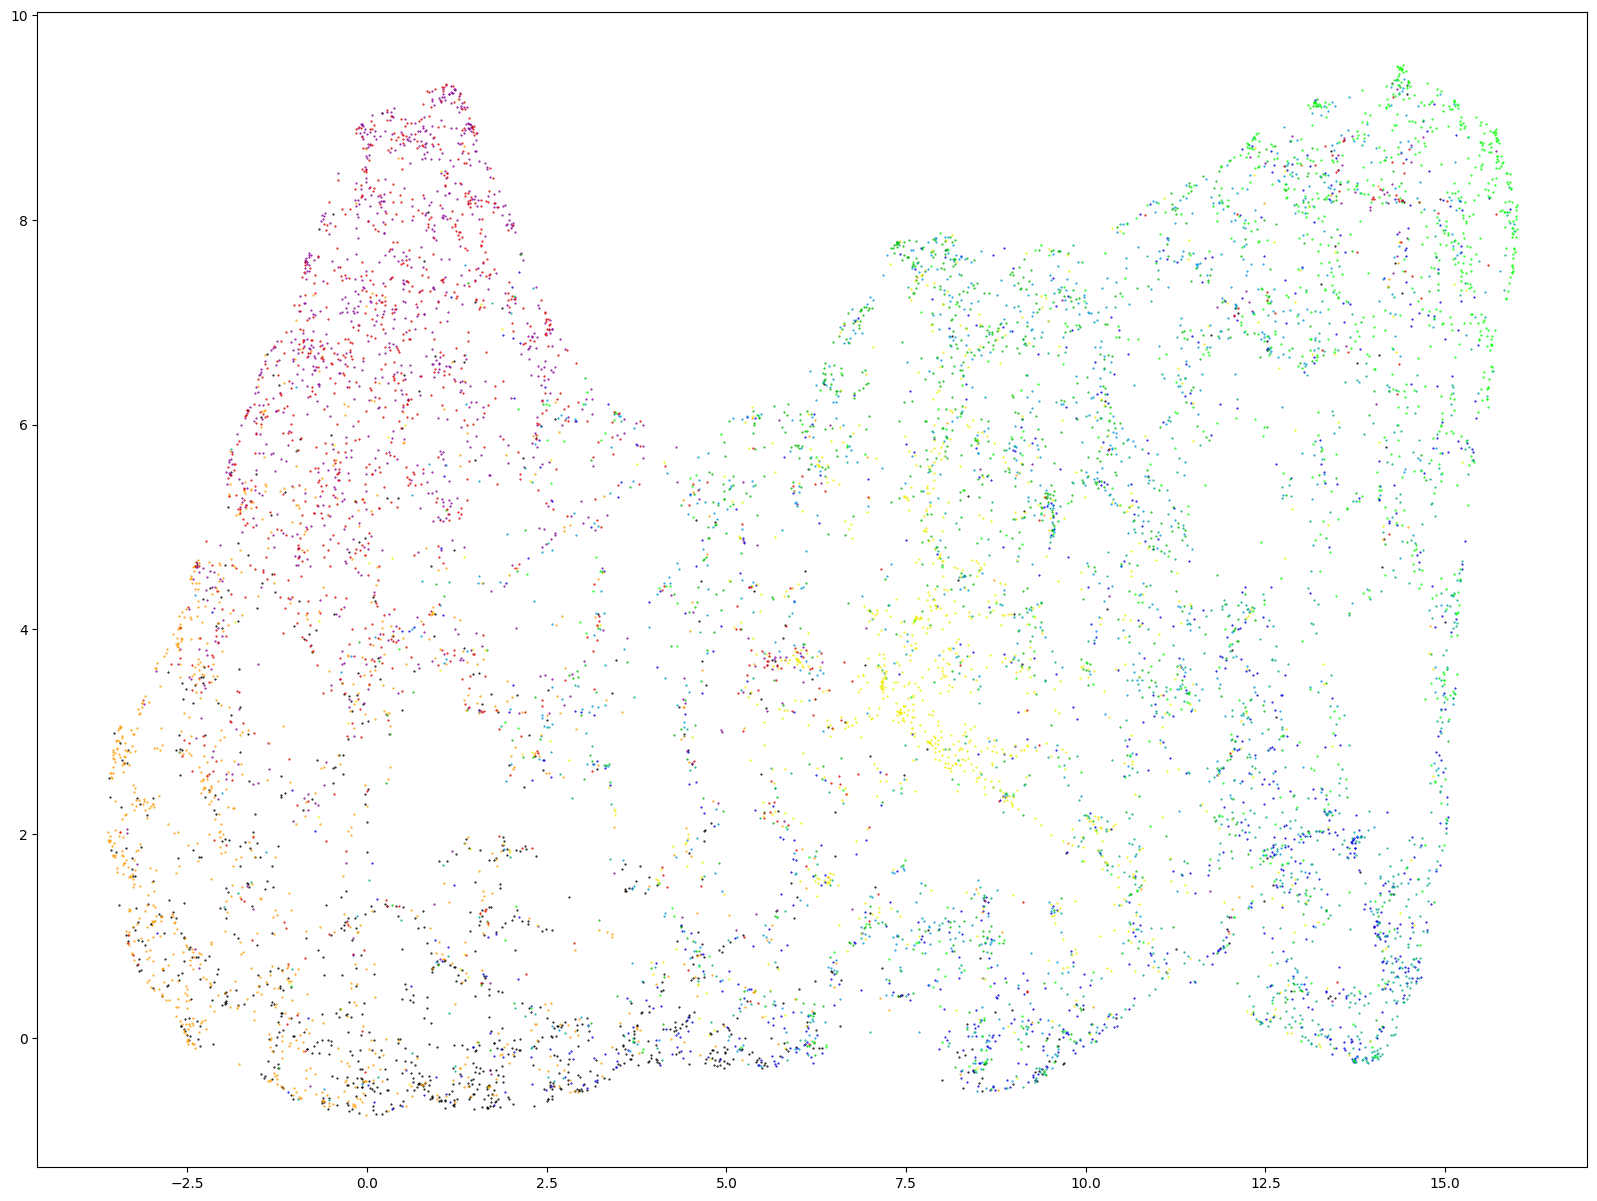

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=1000
INFO:PML:embedding dimensionality is 64
INFO:PML:running k-means clustering with k=10
INFO:PML:embedding dimensionality is 64
INFO:PML:TRAINING EPOCH 5
total_loss=0.21619: 100%|████████████████████████████████████████████████████████████████████████████████████████| 195/195 [10:29<00:00,  3.23s/it]
INFO:PML:Evaluating epoch 5
INFO:PML:Getting embeddings for the val split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.30it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


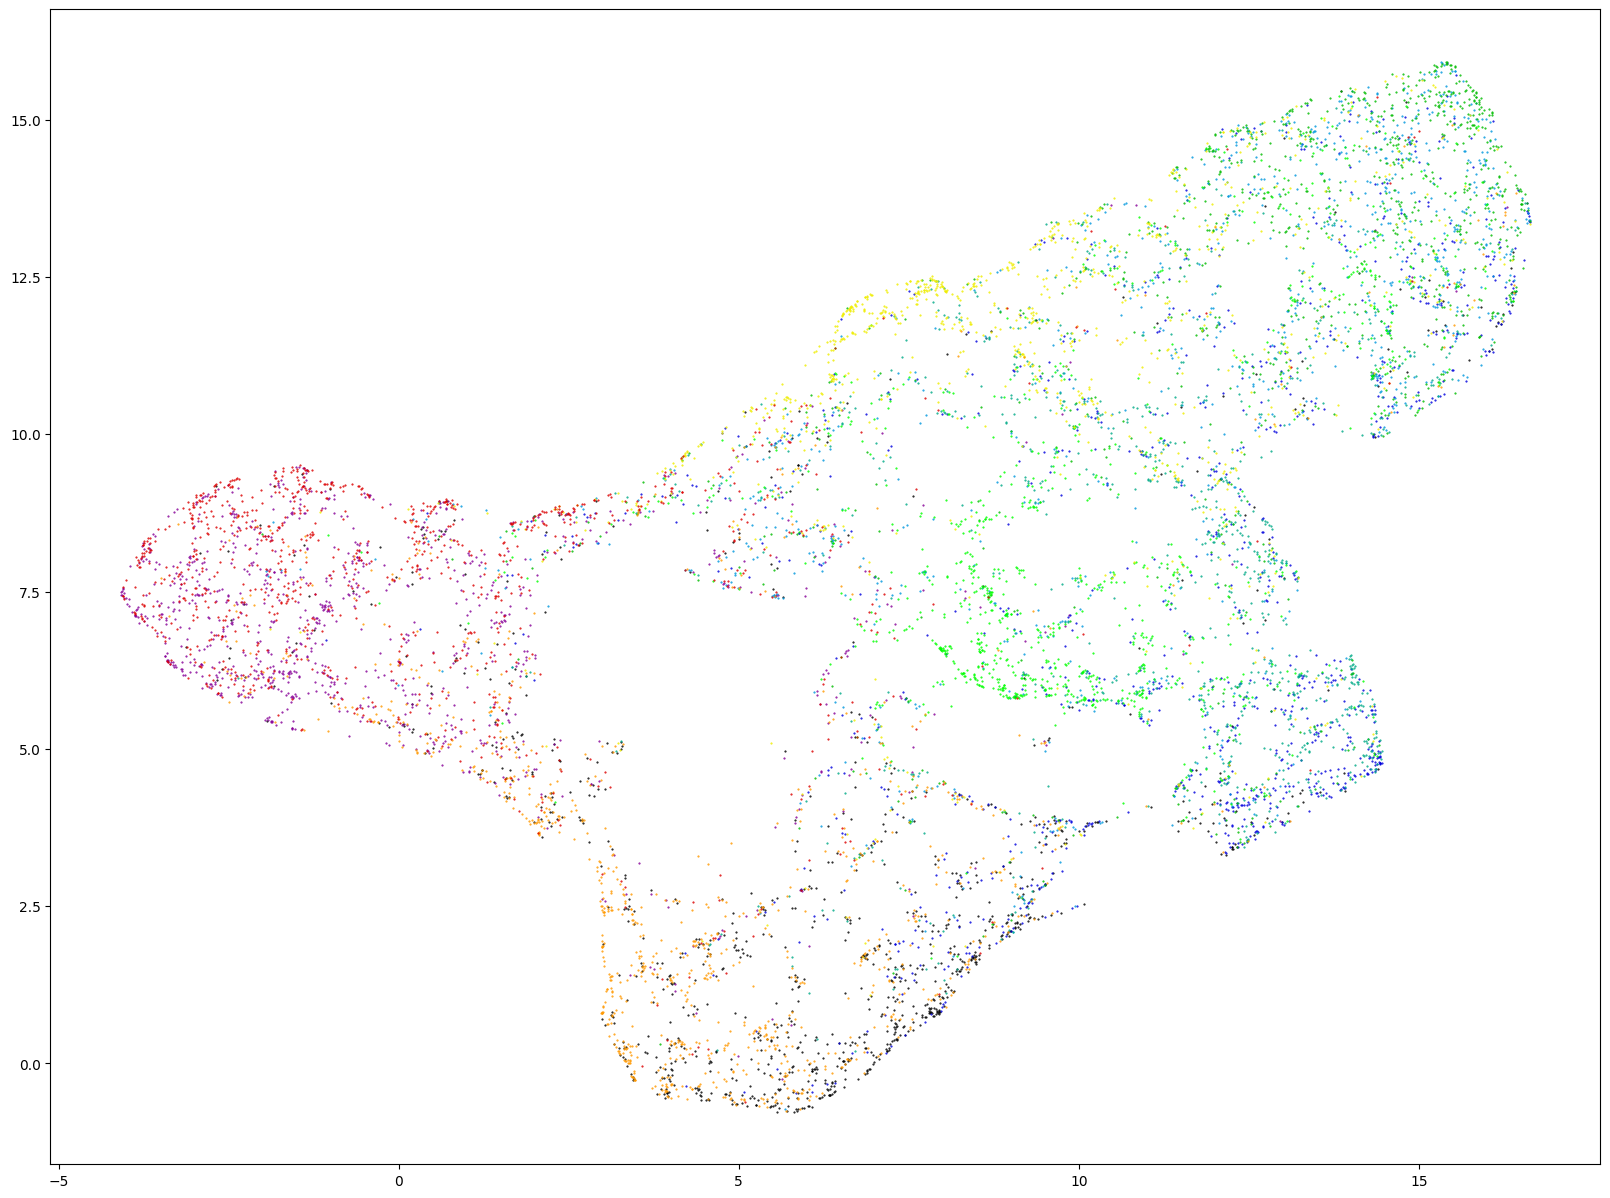

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=1000
INFO:PML:embedding dimensionality is 64
INFO:PML:running k-means clustering with k=10
INFO:PML:embedding dimensionality is 64
INFO:PML:TRAINING EPOCH 6
total_loss=0.20387:  54%|███████████████████████████████████████████████▍                                        | 105/195 [04:36<03:56,  2.63s/it]


KeyboardInterrupt: 

In [58]:
trainer.train(num_epochs=10)

INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the val split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:05<00:00, 54.37it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


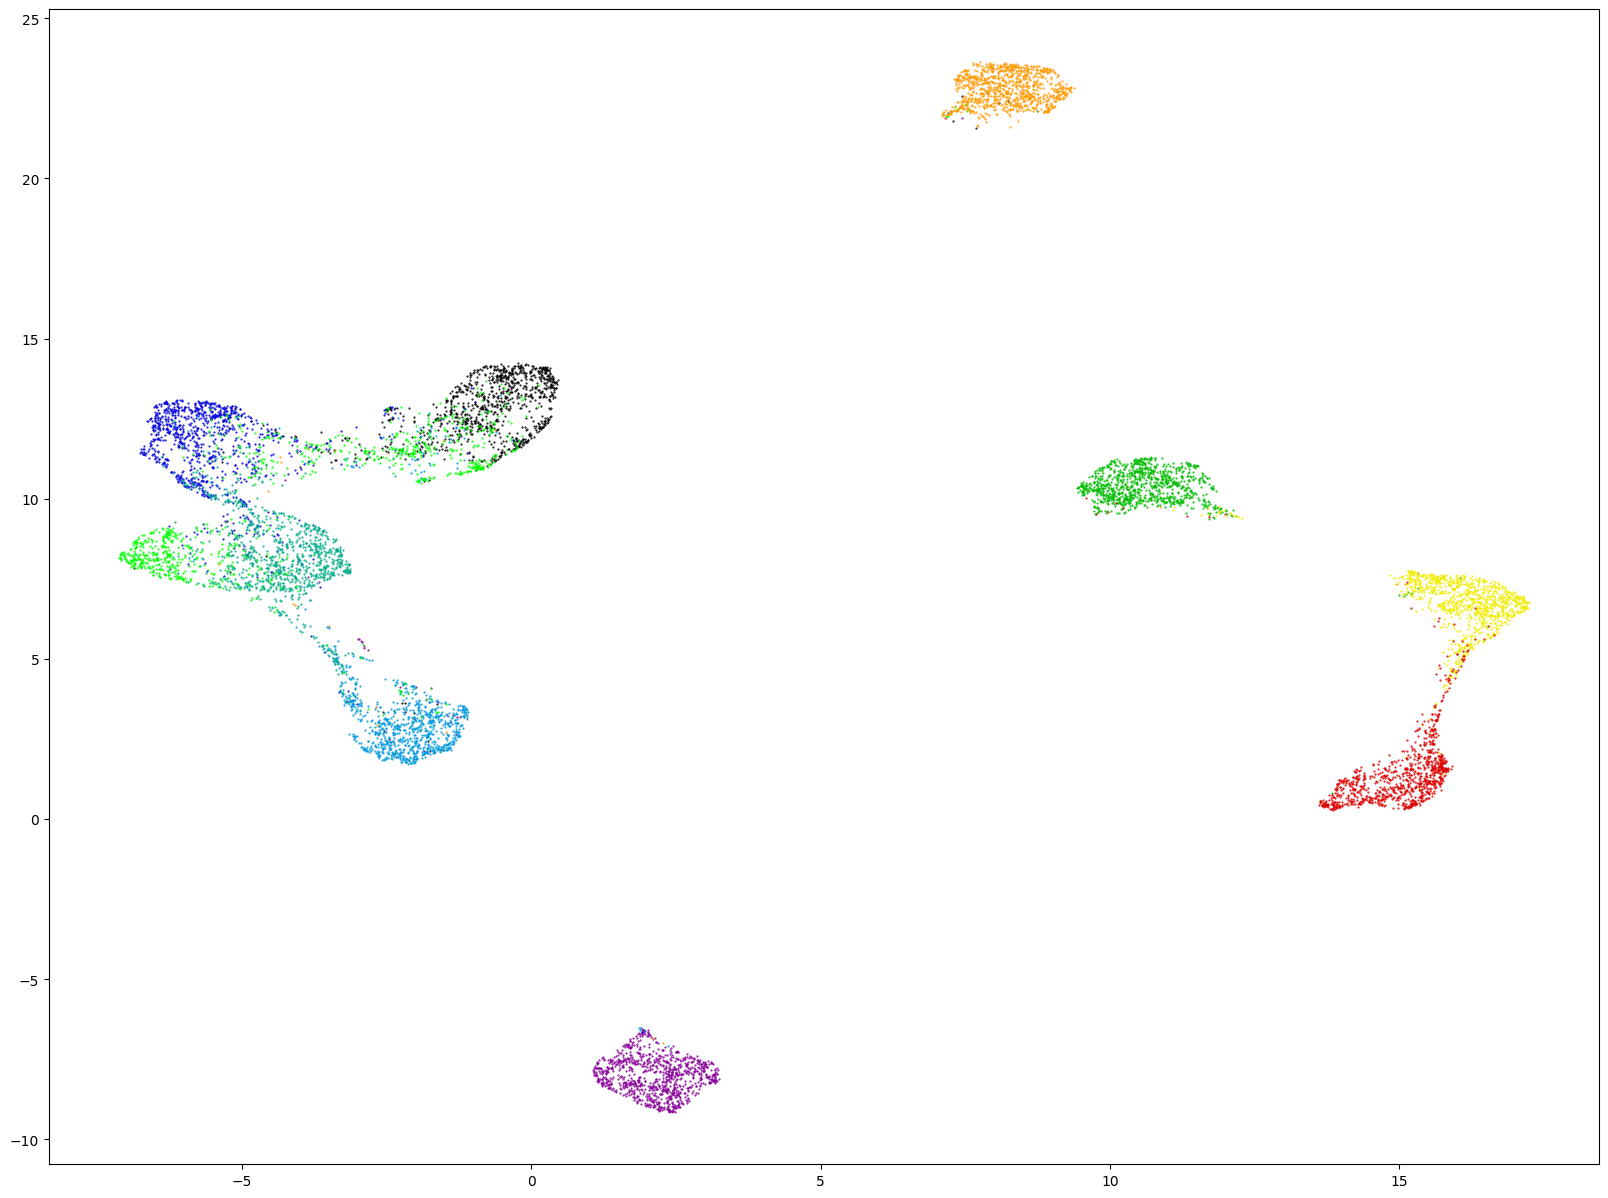

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=1000
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=10
INFO:PML:embedding dimensionality is 128


defaultdict(dict,
            {'val': {'epoch': 1,
              'AMI_level0': 0.7913220400865476,
              'NMI_level0': 0.7916969614539725,
              'mean_average_precision_level0': 0.738643345981587,
              'mean_average_precision_at_r_level0': 0.738643345981587,
              'mean_reciprocal_rank_level0': 0.9158139824867249,
              'precision_at_1_level0': 0.878,
              'r_precision_level0': 0.8008476476476478}})

In [15]:
tester.test(dataset_dict, 1, trunk)